In [31]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
import time
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [32]:
from tqdm.autonotebook import tqdm
tqdm.pandas()

In [33]:
def openCSV(filename):
    '''
    Takes in filename string (with position relative to this location)
    Returns dataframe
    '''
    file = pd.read_csv(filename)
    return pd.DataFrame(file)

In [34]:
# Open all the files
dos_df = openCSV("./DoS_dataset.csv")
fuzzy_df = openCSV("./Fuzzy_dataset.csv")
gear_df = openCSV("./gear_dataset.csv")
rpm_df = openCSV("./RPM_dataset.csv")

# DOS
1. Reformat the data to combine the data payload and to equalize the 8bit and 2bit data
2. Encode to matrix of binary
3. Apply KNN

In [35]:
dos_df.head()

,1478198376.389427,0316,8,05,21,68,09,21.1,21.2,00,6f,R
0,1.478198e+09,018f,8,fe,5b,00,00,00,3c,00,00,R
1,1.478198e+09,0260,8,19,21,22,30,08,8e,6d,3a,R
2,1.478198e+09,02a0,8,64,00,9a,1d,97,02,bd,00,R
3,1.478198e+09,0329,8,40,bb,7f,14,11,20,00,14,R
4,1.478198e+09,0545,8,d8,00,00,8a,00,00,00,00,R


In [36]:
# Add label to the data
dos_df.columns = ["Timestamp","CAN ID","Data size (bytes)","[P","a","Y","L","O","A","D","data]","Label"]
dos_df.head()

,Timestamp,CAN ID,Data size (bytes),[P,a,Y,L,O,A,D,data],Label
0,1.478198e+09,018f,8,fe,5b,00,00,00,3c,00,00,R
1,1.478198e+09,0260,8,19,21,22,30,08,8e,6d,3a,R
2,1.478198e+09,02a0,8,64,00,9a,1d,97,02,bd,00,R
3,1.478198e+09,0329,8,40,bb,7f,14,11,20,00,14,R
4,1.478198e+09,0545,8,d8,00,00,8a,00,00,00,00,R


In [37]:
# Splitting the 2 bytes and 8 bytes data
twob_dos_df = dos_df[dos_df["Label"].isnull()]
eightb_dos_df = dos_df[dos_df["Label"].isnull()  == False]

In [38]:
# Combine payload
eightb_dos_df["data"] = eightb_dos_df['[P'] + eightb_dos_df["a"] + eightb_dos_df["Y"] + eightb_dos_df["L"]  + eightb_dos_df["O"]  + eightb_dos_df["A"]  + eightb_dos_df["D"]  + eightb_dos_df["data]"]
eightb_dos_df.head()

/Users/nanatan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Timestamp,CAN ID,Data size (bytes),[P,a,Y,L,O,A,D,data],Label,data
0,1.478198e+09,018f,8,fe,5b,00,00,00,3c,00,00,R,fe5b0000003c0000
1,1.478198e+09,0260,8,19,21,22,30,08,8e,6d,3a,R,19212230088e6d3a
2,1.478198e+09,02a0,8,64,00,9a,1d,97,02,bd,00,R,64009a1d9702bd00
3,1.478198e+09,0329,8,40,bb,7f,14,11,20,00,14,R,40bb7f1411200014
4,1.478198e+09,0545,8,d8,00,00,8a,00,00,00,00,R,d800008a00000000


In [39]:
# Clean up unused columns
eightb_dos_df = eightb_dos_df.drop(columns=['[P',"a","Y","L","O","A","D","data]"])
eightb_dos_df.head()

,Timestamp,CAN ID,Data size (bytes),Label,data
0,1.478198e+09,018f,8,R,fe5b0000003c0000
1,1.478198e+09,0260,8,R,19212230088e6d3a
2,1.478198e+09,02a0,8,R,64009a1d9702bd00
3,1.478198e+09,0329,8,R,40bb7f1411200014
4,1.478198e+09,0545,8,R,d800008a00000000


In [40]:
# Label and clean up the 2 bytes entries
twob_dos_df = twob_dos_df.dropna(axis='columns')
twob_dos_df.columns = ["Timestamp","CAN ID","Data size (bytes)","[Payload","Data]","Label"]
twob_dos_df.head()

,Timestamp,CAN ID,Data size (bytes),[Payload,Data],Label
35,1.478198e+09,05f0,2,01,00,R
134,1.478198e+09,05f0,2,01,00,R
226,1.478198e+09,05f0,2,01,00,R
319,1.478198e+09,05f0,2,01,00,R
411,1.478198e+09,05f0,2,01,00,R


In [41]:
# Combine payload for 2 bytes entries
twob_dos_df["data"] = twob_dos_df['[Payload'] + twob_dos_df["Data]"]
twob_dos_df.head()

,Timestamp,CAN ID,Data size (bytes),[Payload,Data],Label,data
35,1.478198e+09,05f0,2,01,00,R,0100
134,1.478198e+09,05f0,2,01,00,R,0100
226,1.478198e+09,05f0,2,01,00,R,0100
319,1.478198e+09,05f0,2,01,00,R,0100
411,1.478198e+09,05f0,2,01,00,R,0100


In [42]:
# Clean up unused label 
twob_dos_df = twob_dos_df.drop(columns=['[Payload',"Data]"])
twob_dos_df.head()

,Timestamp,CAN ID,Data size (bytes),Label,data
35,1.478198e+09,05f0,2,R,0100
134,1.478198e+09,05f0,2,R,0100
226,1.478198e+09,05f0,2,R,0100
319,1.478198e+09,05f0,2,R,0100
411,1.478198e+09,05f0,2,R,0100


In [43]:
# Combine the 8bytes and 2bytes entries together
frames = [eightb_dos_df,twob_dos_df]
dos_formatted = pd.concat(frames)

In [44]:
dos_formatted.head()

,Timestamp,CAN ID,Data size (bytes),Label,data
0,1.478198e+09,018f,8,R,fe5b0000003c0000
1,1.478198e+09,0260,8,R,19212230088e6d3a
2,1.478198e+09,02a0,8,R,64009a1d9702bd00
3,1.478198e+09,0329,8,R,40bb7f1411200014
4,1.478198e+09,0545,8,R,d800008a00000000


In [45]:
# Return dataframe to the same order as original based on timestamp
dos_formatted = dos_formatted.sort_values(by=['Timestamp'])
dos_formatted.tail()

,Timestamp,CAN ID,Data size (bytes),Label,data
3665765,1.478201e+09,018f,8,R,fe59000000410000
3665766,1.478201e+09,0260,8,R,18212130088f6d19
3665767,1.478201e+09,02a0,8,R,24009a1d9702bd00
3665768,1.478201e+09,0329,8,R,dcb77f1411200014
3665769,1.478201e+09,0545,8,R,d800008b00000000


# Until here has been reformatting and combining the 2 bytes and 8 bytes data. 

In [46]:
# Convert CAN ID to int representation
dos_formatted['CAN ID'] = [int(x,16) for x in dos_formatted['CAN ID']]
dos_formatted.head()


,Timestamp,CAN ID,Data size (bytes),Label,data
0,1.478198e+09,399,8,R,fe5b0000003c0000
1,1.478198e+09,608,8,R,19212230088e6d3a
2,1.478198e+09,672,8,R,64009a1d9702bd00
3,1.478198e+09,809,8,R,40bb7f1411200014
4,1.478198e+09,1349,8,R,d800008a00000000


In [151]:
# Let's only take 5000 sample
dos_formatted_5k = dos_formatted[:10000]

In [152]:
class MsgData:
    def __init__(self,can_id,time,index):
        self.can_id = can_id
        self.last_occured = time
        self.last_index = index
    
    def updateTime(self,time):
        self.last_occured = time
        
    def updateIndex(self,index):
        self.last_index = index 
        
    def getTimeDiff(self,time):
        return time - self.last_occured
    
    def getIndex(self):
        return self.last_index

In [153]:
'''
id: xxxx
last_occured: <time>
data: []
data_count = x

keep last occured index rather than data
then it can look for the data itself later on
'''
hashtable = {}
time_series = []
data_series = []
data_len_series = []

for index, row in dos_formatted_5k.iterrows():
    if row['CAN ID'] not in hashtable:
        hashtable[row['CAN ID']] = MsgData(row['CAN ID'],row['Timestamp'],index)
    #get the time difference
    time_series.append(hashtable[row['CAN ID']].getTimeDiff(row['Timestamp']))
    #write down the data in between
#     print("get data from index",hashtable[row['CAN ID']].getIndex()," to index",index)
    data_inbetween = dos_formatted_5k.loc[np.r_[hashtable[row['CAN ID']].getIndex()+1:index]]['CAN ID'].values
    data_series.append(data_inbetween)
    #might as well do the length
    data_len_series.append(len(data_inbetween))
    #update everything
    hashtable[row['CAN ID']].updateTime(row['Timestamp'])
    hashtable[row['CAN ID']].updateIndex(index)
    hashtable[row['CAN ID']].updateTime(row['Timestamp'])
    

get data from index 0  to index 0
get data from index 1  to index 1
get data from index 2  to index 2
get data from index 3  to index 3
get data from index 4  to index 4
get data from index 5  to index 5
get data from index 6  to index 6
get data from index 7  to index 7
get data from index 8  to index 8
get data from index 9  to index 9
get data from index 10  to index 10
get data from index 11  to index 11
get data from index 12  to index 12
get data from index 13  to index 13
get data from index 14  to index 14
get data from index 15  to index 15
get data from index 0  to index 16
get data from index 1  to index 17
get data from index 2  to index 18
get data from index 3  to index 19
get data from index 20  to index 20
get data from index 4  to index 21
get data from index 22  to index 22
get data from index 23  to index 23
get data from index 24  to index 24
get data from index 6  to index 25
get data from index 5  to index 26
get data from index 7  to index 27
get data from index 

get data from index 349  to index 369
get data from index 350  to index 370
get data from index 351  to index 371
get data from index 352  to index 372
get data from index 353  to index 373
get data from index 355  to index 374
get data from index 360  to index 375
get data from index 359  to index 376
get data from index 361  to index 377
get data from index 363  to index 378
get data from index 364  to index 379
get data from index 365  to index 380
get data from index 362  to index 381
get data from index 367  to index 382
get data from index 366  to index 383
get data from index 368  to index 384
get data from index 369  to index 385
get data from index 370  to index 386
get data from index 371  to index 387
get data from index 372  to index 388
get data from index 373  to index 389
get data from index 354  to index 390
get data from index 374  to index 391
get data from index 356  to index 392
get data from index 357  to index 393
get data from index 358  to index 394
get data fro

get data from index 684  to index 705
get data from index 685  to index 706
get data from index 686  to index 707
get data from index 687  to index 708
get data from index 694  to index 709
get data from index 693  to index 710
get data from index 695  to index 711
get data from index 697  to index 712
get data from index 698  to index 713
get data from index 699  to index 714
get data from index 696  to index 715
get data from index 701  to index 716
get data from index 700  to index 717
get data from index 702  to index 718
get data from index 703  to index 719
get data from index 704  to index 720
get data from index 705  to index 721
get data from index 706  to index 722
get data from index 707  to index 723
get data from index 708  to index 724
get data from index 688  to index 725
get data from index 690  to index 726
get data from index 691  to index 727
get data from index 692  to index 728
get data from index 710  to index 729
get data from index 709  to index 730
get data fro

get data from index 1051  to index 1072
get data from index 1052  to index 1073
get data from index 1053  to index 1074
get data from index 1054  to index 1075
get data from index 1055  to index 1076
get data from index 1056  to index 1077
get data from index 1057  to index 1078
get data from index 1064  to index 1079
get data from index 1063  to index 1080
get data from index 1065  to index 1081
get data from index 1067  to index 1082
get data from index 1068  to index 1083
get data from index 1069  to index 1084
get data from index 1066  to index 1085
get data from index 1071  to index 1086
get data from index 1070  to index 1087
get data from index 1072  to index 1088
get data from index 1073  to index 1089
get data from index 1074  to index 1090
get data from index 1075  to index 1091
get data from index 1076  to index 1092
get data from index 1077  to index 1093
get data from index 1078  to index 1094
get data from index 1058  to index 1095
get data from index 1060  to index 1096


get data from index 1426  to index 1447
get data from index 1427  to index 1448
get data from index 1428  to index 1449
get data from index 1429  to index 1450
get data from index 1437  to index 1451
get data from index 1436  to index 1452
get data from index 1433  to index 1453
get data from index 1439  to index 1454
get data from index 1440  to index 1455
get data from index 1441  to index 1456
get data from index 1438  to index 1457
get data from index 1443  to index 1458
get data from index 1442  to index 1459
get data from index 1444  to index 1460
get data from index 1445  to index 1461
get data from index 1446  to index 1462
get data from index 1447  to index 1463
get data from index 1448  to index 1464
get data from index 1449  to index 1465
get data from index 1450  to index 1466
get data from index 1430  to index 1467
get data from index 1432  to index 1468
get data from index 1453  to index 1469
get data from index 1434  to index 1470
get data from index 1435  to index 1471


get data from index 1821  to index 1822
get data from index 1822  to index 1823
get data from index 1773  to index 1824
get data from index 1823  to index 1825
get data from index 1775  to index 1826
get data from index 1825  to index 1827
get data from index 1779  to index 1828
get data from index 1827  to index 1829
get data from index 1781  to index 1830
get data from index 1810  to index 1831
get data from index 1826  to index 1832
get data from index 1829  to index 1833
get data from index 1824  to index 1834
get data from index 1833  to index 1835
get data from index 1828  to index 1836
get data from index 1835  to index 1837
get data from index 1830  to index 1838
get data from index 1837  to index 1839
get data from index 1783  to index 1840
get data from index 1839  to index 1841
get data from index 1785  to index 1842
get data from index 1841  to index 1843
get data from index 1787  to index 1844
get data from index 1843  to index 1845
get data from index 1808  to index 1846


get data from index 2157  to index 2197
get data from index 2196  to index 2198
get data from index 2161  to index 2199
get data from index 2198  to index 2200
get data from index 2070  to index 2201
get data from index 2200  to index 2202
get data from index 2187  to index 2203
get data from index 2202  to index 2204
get data from index 2185  to index 2205
get data from index 2204  to index 2206
get data from index 2203  to index 2207
get data from index 2206  to index 2208
get data from index 2199  to index 2209
get data from index 2208  to index 2210
get data from index 2210  to index 2211
get data from index 2189  to index 2212
get data from index 2211  to index 2213
get data from index 2191  to index 2214
get data from index 2213  to index 2215
get data from index 2193  to index 2216
get data from index 2215  to index 2217
get data from index 2195  to index 2218
get data from index 2217  to index 2219
get data from index 2197  to index 2220
get data from index 2219  to index 2221


get data from index 2572  to index 2576
get data from index 2539  to index 2577
get data from index 2576  to index 2578
get data from index 2541  to index 2579
get data from index 2578  to index 2580
get data from index 2565  to index 2581
get data from index 2580  to index 2582
get data from index 2531  to index 2583
get data from index 2582  to index 2584
get data from index 2543  to index 2585
get data from index 2584  to index 2586
get data from index 2545  to index 2587
get data from index 2586  to index 2588
get data from index 2557  to index 2589
get data from index 2588  to index 2590
get data from index 2553  to index 2591
get data from index 2581  to index 2592
get data from index 2590  to index 2593
get data from index 2567  to index 2594
get data from index 2593  to index 2595
get data from index 2569  to index 2596
get data from index 2595  to index 2597
get data from index 2571  to index 2598
get data from index 2597  to index 2599
get data from index 2574  to index 2600


get data from index 2779  to index 2781
get data from index 2598  to index 2782
get data from index 2781  to index 2783
get data from index 2762  to index 2784
get data from index 2783  to index 2785
get data from index 2749  to index 2786
get data from index 2785  to index 2787
get data from index 2756  to index 2788
get data from index 2787  to index 2789
get data from index 2738  to index 2790
get data from index 2789  to index 2791
get data from index 2740  to index 2792
get data from index 2791  to index 2793
get data from index 2742  to index 2794
get data from index 2793  to index 2795
get data from index 2758  to index 2796
get data from index 2795  to index 2797
get data from index 2712  to index 2798
get data from index 2797  to index 2799
get data from index 2761  to index 2800
get data from index 2799  to index 2801
get data from index 2721  to index 2802
get data from index 2801  to index 2803
get data from index 2764  to index 2804
get data from index 2803  to index 2805


get data from index 3193  to index 3196
get data from index 3196  to index 3197
get data from index 3110  to index 3198
get data from index 3197  to index 3199
get data from index 2928  to index 3200
get data from index 3199  to index 3201
get data from index 2930  to index 3202
get data from index 3201  to index 3203
get data from index 2958  to index 3204
get data from index 3203  to index 3205
get data from index 3102  to index 3206
get data from index 3205  to index 3207
get data from index 3100  to index 3208
get data from index 3207  to index 3209
get data from index 3112  to index 3210
get data from index 3209  to index 3211
get data from index 3178  to index 3212
get data from index 3211  to index 3213
get data from index 3172  to index 3214
get data from index 3194  to index 3215
get data from index 3213  to index 3216
get data from index 3216  to index 3217
get data from index 3217  to index 3218
get data from index 3198  to index 3219
get data from index 3218  to index 3220


get data from index 3580  to index 3582
get data from index 3502  to index 3583
get data from index 3582  to index 3584
get data from index 3548  to index 3585
get data from index 3584  to index 3586
get data from index 3550  to index 3587
get data from index 3586  to index 3588
get data from index 3507  to index 3589
get data from index 3588  to index 3590
get data from index 3590  to index 3591
get data from index 3510  to index 3592
get data from index 3591  to index 3593
get data from index 3593  to index 3594
get data from index 3563  to index 3595
get data from index 3594  to index 3596
get data from index 3596  to index 3597
get data from index 3474  to index 3598
get data from index 3597  to index 3599
get data from index 3557  to index 3600
get data from index 3599  to index 3601
get data from index 3559  to index 3602
get data from index 3601  to index 3603
get data from index 3561  to index 3604
get data from index 3603  to index 3605
get data from index 3595  to index 3606


get data from index 3881  to index 3948
get data from index 3947  to index 3949
get data from index 3883  to index 3950
get data from index 3949  to index 3951
get data from index 3885  to index 3952
get data from index 3951  to index 3953
get data from index 3915  to index 3954
get data from index 3953  to index 3955
get data from index 3917  to index 3956
get data from index 3955  to index 3957
get data from index 3919  to index 3958
get data from index 3957  to index 3959
get data from index 3942  to index 3960
get data from index 3959  to index 3961
get data from index 3944  to index 3962
get data from index 3961  to index 3963
get data from index 3925  to index 3964
get data from index 3963  to index 3965
get data from index 3927  to index 3966
get data from index 3965  to index 3967
get data from index 3929  to index 3968
get data from index 3958  to index 3969
get data from index 3967  to index 3970
get data from index 3970  to index 3971
get data from index 3952  to index 3972


get data from index 4343  to index 4346
get data from index 4345  to index 4347
get data from index 4336  to index 4348
get data from index 4347  to index 4349
get data from index 4330  to index 4350
get data from index 4349  to index 4351
get data from index 4332  to index 4352
get data from index 4351  to index 4353
get data from index 4334  to index 4354
get data from index 4353  to index 4355
get data from index 4338  to index 4356
get data from index 4355  to index 4357
get data from index 4256  to index 4358
get data from index 4357  to index 4359
get data from index 4258  to index 4360
get data from index 4359  to index 4361
get data from index 4361  to index 4362
get data from index 4173  to index 4363
get data from index 4362  to index 4364
get data from index 4364  to index 4365
get data from index 4238  to index 4366
get data from index 4365  to index 4367
get data from index 4367  to index 4368
get data from index 4368  to index 4369
get data from index 4242  to index 4370


get data from index 4704  to index 4716
get data from index 4715  to index 4717
get data from index 4696  to index 4718
get data from index 4717  to index 4719
get data from index 4698  to index 4720
get data from index 4719  to index 4721
get data from index 4682  to index 4722
get data from index 4721  to index 4723
get data from index 4635  to index 4724
get data from index 4723  to index 4725
get data from index 4706  to index 4726
get data from index 4725  to index 4727
get data from index 4708  to index 4728
get data from index 4727  to index 4729
get data from index 4710  to index 4730
get data from index 4729  to index 4731
get data from index 4712  to index 4732
get data from index 4731  to index 4733
get data from index 4668  to index 4734
get data from index 4733  to index 4735
get data from index 4613  to index 4736
get data from index 4735  to index 4737
get data from index 4570  to index 4738
get data from index 4737  to index 4739
get data from index 4363  to index 4740


get data from index 4928  to index 4930
get data from index 4846  to index 4931
get data from index 4930  to index 4932
get data from index 4869  to index 4933
get data from index 4932  to index 4934
get data from index 4873  to index 4935
get data from index 4934  to index 4936
get data from index 4852  to index 4937
get data from index 4936  to index 4938
get data from index 4938  to index 4939
get data from index 4878  to index 4940
get data from index 4939  to index 4941
get data from index 4880  to index 4942
get data from index 4941  to index 4943
get data from index 4882  to index 4944
get data from index 4943  to index 4945
get data from index 4902  to index 4946
get data from index 4945  to index 4947
get data from index 4900  to index 4948
get data from index 4947  to index 4949
get data from index 4914  to index 4950
get data from index 4949  to index 4951
get data from index 4916  to index 4952
get data from index 4951  to index 4953
get data from index 4908  to index 4954


get data from index 5319  to index 5320
get data from index 5320  to index 5321
get data from index 5138  to index 5322
get data from index 5321  to index 5323
get data from index 5291  to index 5324
get data from index 5323  to index 5325
get data from index 5293  to index 5326
get data from index 5325  to index 5327
get data from index 5301  to index 5328
get data from index 5327  to index 5329
get data from index 5303  to index 5330
get data from index 5329  to index 5331
get data from index 5305  to index 5332
get data from index 5331  to index 5333
get data from index 5299  to index 5334
get data from index 5333  to index 5335
get data from index 5307  to index 5336
get data from index 5335  to index 5337
get data from index 5309  to index 5338
get data from index 5337  to index 5339
get data from index 5313  to index 5340
get data from index 5339  to index 5341
get data from index 5311  to index 5342
get data from index 5341  to index 5343
get data from index 5317  to index 5344


get data from index 5659  to index 5661
get data from index 5644  to index 5662
get data from index 5661  to index 5663
get data from index 5646  to index 5664
get data from index 5663  to index 5665
get data from index 5648  to index 5666
get data from index 5665  to index 5667
get data from index 5612  to index 5668
get data from index 5667  to index 5669
get data from index 5604  to index 5670
get data from index 5669  to index 5671
get data from index 5606  to index 5672
get data from index 5671  to index 5673
get data from index 5608  to index 5674
get data from index 5673  to index 5675
get data from index 5610  to index 5676
get data from index 5675  to index 5677
get data from index 5633  to index 5678
get data from index 5677  to index 5679
get data from index 5635  to index 5680
get data from index 5679  to index 5681
get data from index 5637  to index 5682
get data from index 5681  to index 5683
get data from index 5662  to index 5684
get data from index 5683  to index 5685


get data from index 6028  to index 6055
get data from index 6054  to index 6056
get data from index 6047  to index 6057
get data from index 6056  to index 6058
get data from index 6045  to index 6059
get data from index 6058  to index 6060
get data from index 6051  to index 6061
get data from index 6060  to index 6062
get data from index 6053  to index 6063
get data from index 6062  to index 6064
get data from index 6055  to index 6065
get data from index 6064  to index 6066
get data from index 6018  to index 6067
get data from index 6066  to index 6068
get data from index 6049  to index 6069
get data from index 6068  to index 6070
get data from index 6070  to index 6071
get data from index 5598  to index 6072
get data from index 6071  to index 6073
get data from index 6073  to index 6074
get data from index 6074  to index 6075
get data from index 6075  to index 6076
get data from index 6010  to index 6077
get data from index 6076  to index 6078
get data from index 6012  to index 6079


get data from index 6436  to index 6438
get data from index 6403  to index 6439
get data from index 6438  to index 6440
get data from index 6414  to index 6441
get data from index 6440  to index 6442
get data from index 6404  to index 6443
get data from index 6442  to index 6444
get data from index 6401  to index 6445
get data from index 6444  to index 6446
get data from index 6381  to index 6447
get data from index 6446  to index 6448
get data from index 6383  to index 6449
get data from index 6448  to index 6450
get data from index 6407  to index 6451
get data from index 6450  to index 6452
get data from index 6409  to index 6453
get data from index 6224  to index 6454
get data from index 6431  to index 6455
get data from index 6452  to index 6456
get data from index 6399  to index 6457
get data from index 6456  to index 6458
get data from index 6412  to index 6459
get data from index 6458  to index 6460
get data from index 6441  to index 6461
get data from index 6460  to index 6462


get data from index 6798  to index 6819
get data from index 6818  to index 6820
get data from index 6780  to index 6821
get data from index 6820  to index 6822
get data from index 6782  to index 6823
get data from index 6822  to index 6824
get data from index 6786  to index 6825
get data from index 6788  to index 6826
get data from index 6790  to index 6827
get data from index 6824  to index 6828
get data from index 6792  to index 6829
get data from index 6828  to index 6830
get data from index 6794  to index 6831
get data from index 6830  to index 6832
get data from index 6750  to index 6833
get data from index 6832  to index 6834
get data from index 6748  to index 6835
get data from index 6834  to index 6836
get data from index 6751  to index 6837
get data from index 6836  to index 6838
get data from index 6752  to index 6839
get data from index 6838  to index 6840
get data from index 6840  to index 6841
get data from index 6841  to index 6842
get data from index 6842  to index 6843


get data from index 7036  to index 7038
get data from index 7006  to index 7039
get data from index 7038  to index 7040
get data from index 7008  to index 7041
get data from index 7040  to index 7042
get data from index 7010  to index 7043
get data from index 7042  to index 7044
get data from index 7012  to index 7045
get data from index 7044  to index 7046
get data from index 7014  to index 7047
get data from index 7046  to index 7048
get data from index 7016  to index 7049
get data from index 7048  to index 7050
get data from index 7020  to index 7051
get data from index 7050  to index 7052
get data from index 7022  to index 7053
get data from index 7052  to index 7054
get data from index 7024  to index 7055
get data from index 7054  to index 7056
get data from index 7018  to index 7057
get data from index 7056  to index 7058
get data from index 6951  to index 7059
get data from index 7058  to index 7060
get data from index 7060  to index 7061
get data from index 7061  to index 7062


get data from index 7441  to index 7443
get data from index 7443  to index 7444
get data from index 7444  to index 7445
get data from index 7377  to index 7446
get data from index 7445  to index 7447
get data from index 7379  to index 7448
get data from index 7447  to index 7449
get data from index 7383  to index 7450
get data from index 7449  to index 7451
get data from index 7413  to index 7452
get data from index 7451  to index 7453
get data from index 7415  to index 7454
get data from index 7453  to index 7455
get data from index 7423  to index 7456
get data from index 7455  to index 7457
get data from index 7417  to index 7458
get data from index 7457  to index 7459
get data from index 7419  to index 7460
get data from index 7459  to index 7461
get data from index 7421  to index 7462
get data from index 7461  to index 7463
get data from index 7425  to index 7464
get data from index 7463  to index 7465
get data from index 7381  to index 7466
get data from index 7465  to index 7467


get data from index 7649  to index 7651
get data from index 7651  to index 7652
get data from index 7652  to index 7653
get data from index 7653  to index 7654
get data from index 7597  to index 7655
get data from index 7654  to index 7656
get data from index 7636  to index 7657
get data from index 7656  to index 7658
get data from index 7658  to index 7659
get data from index 7624  to index 7660
get data from index 7659  to index 7661
get data from index 7628  to index 7662
get data from index 7661  to index 7663
get data from index 7630  to index 7664
get data from index 7663  to index 7665
get data from index 7632  to index 7666
get data from index 7665  to index 7667
get data from index 7634  to index 7668
get data from index 7667  to index 7669
get data from index 7638  to index 7670
get data from index 7669  to index 7671
get data from index 7644  to index 7672
get data from index 7671  to index 7673
get data from index 7640  to index 7674
get data from index 7673  to index 7675


get data from index 7986  to index 7988
get data from index 7988  to index 7989
get data from index 7989  to index 7990
get data from index 7990  to index 7991
get data from index 7991  to index 7992
get data from index 7953  to index 7993
get data from index 7992  to index 7994
get data from index 7933  to index 7995
get data from index 7994  to index 7996
get data from index 7935  to index 7997
get data from index 7996  to index 7998
get data from index 7937  to index 7999
get data from index 7998  to index 8000
get data from index 7976  to index 8001
get data from index 8000  to index 8002
get data from index 7957  to index 8003
get data from index 8002  to index 8004
get data from index 7967  to index 8005
get data from index 8004  to index 8006
get data from index 7970  to index 8007
get data from index 8006  to index 8008
get data from index 7971  to index 8009
get data from index 8008  to index 8010
get data from index 7973  to index 8011
get data from index 8010  to index 8012


get data from index 8163  to index 8193
get data from index 8192  to index 8194
get data from index 8165  to index 8195
get data from index 8194  to index 8196
get data from index 8167  to index 8197
get data from index 8196  to index 8198
get data from index 8169  to index 8199
get data from index 8198  to index 8200
get data from index 8173  to index 8201
get data from index 8200  to index 8202
get data from index 8175  to index 8203
get data from index 8202  to index 8204
get data from index 8177  to index 8205
get data from index 8204  to index 8206
get data from index 8179  to index 8207
get data from index 8206  to index 8208
get data from index 8171  to index 8209
get data from index 8208  to index 8210
get data from index 8148  to index 8211
get data from index 8210  to index 8212
get data from index 7987  to index 8213
get data from index 8212  to index 8214
get data from index 8214  to index 8215
get data from index 8215  to index 8216
get data from index 8216  to index 8217


get data from index 8410  to index 8412
get data from index 8400  to index 8413
get data from index 8412  to index 8414
get data from index 8402  to index 8415
get data from index 8414  to index 8416
get data from index 8369  to index 8417
get data from index 8416  to index 8418
get data from index 8418  to index 8419
get data from index 8409  to index 8420
get data from index 8419  to index 8421
get data from index 8421  to index 8422
get data from index 8394  to index 8423
get data from index 8345  to index 8424
get data from index 8415  to index 8425
get data from index 8422  to index 8426
get data from index 8426  to index 8427
get data from index 8349  to index 8428
get data from index 8417  to index 8429
get data from index 8423  to index 8430
get data from index 8427  to index 8431
get data from index 8431  to index 8432
get data from index 8432  to index 8433
get data from index 8433  to index 8434
get data from index 8434  to index 8435
get data from index 8387  to index 8436


get data from index 8613  to index 8630
get data from index 8614  to index 8631
get data from index 8615  to index 8632
get data from index 8617  to index 8633
get data from index 8598  to index 8634
get data from index 8618  to index 8635
get data from index 8600  to index 8636
get data from index 8601  to index 8637
get data from index 8602  to index 8638
get data from index 8620  to index 8639
get data from index 8619  to index 8640
get data from index 8624  to index 8641
get data from index 8621  to index 8642
get data from index 8622  to index 8643
get data from index 8623  to index 8644
get data from index 8625  to index 8645
get data from index 8626  to index 8646
get data from index 8627  to index 8647
get data from index 8628  to index 8648
get data from index 8630  to index 8649
get data from index 8631  to index 8650
get data from index 8632  to index 8651
get data from index 8629  to index 8652
get data from index 8633  to index 8653
get data from index 8635  to index 8654


get data from index 8950  to index 8971
get data from index 8951  to index 8972
get data from index 8955  to index 8973
get data from index 8949  to index 8974
get data from index 8956  to index 8975
get data from index 8960  to index 8976
get data from index 8957  to index 8977
get data from index 8958  to index 8978
get data from index 8959  to index 8979
get data from index 8961  to index 8980
get data from index 8942  to index 8981
get data from index 8965  to index 8982
get data from index 8944  to index 8983
get data from index 8945  to index 8984
get data from index 8946  to index 8985
get data from index 8967  to index 8986
get data from index 8966  to index 8987
get data from index 8974  to index 8988
get data from index 8971  to index 8989
get data from index 8968  to index 8990
get data from index 8969  to index 8991
get data from index 8970  to index 8992
get data from index 8972  to index 8993
get data from index 8973  to index 8994
get data from index 8975  to index 8995


get data from index 9174  to index 9192
get data from index 9175  to index 9193
get data from index 9179  to index 9194
get data from index 9173  to index 9195
get data from index 9180  to index 9196
get data from index 9184  to index 9197
get data from index 9181  to index 9198
get data from index 9182  to index 9199
get data from index 9183  to index 9200
get data from index 9185  to index 9201
get data from index 9166  to index 9202
get data from index 9018  to index 9203
get data from index 9186  to index 9204
get data from index 9168  to index 9205
get data from index 9169  to index 9206
get data from index 9170  to index 9207
get data from index 9188  to index 9208
get data from index 9187  to index 9209
get data from index 9195  to index 9210
get data from index 9192  to index 9211
get data from index 9193  to index 9212
get data from index 9189  to index 9213
get data from index 9190  to index 9214
get data from index 9191  to index 9215
get data from index 9194  to index 9216


get data from index 9418  to index 9439
get data from index 9419  to index 9440
get data from index 9420  to index 9441
get data from index 9421  to index 9442
get data from index 9422  to index 9443
get data from index 9423  to index 9444
get data from index 9426  to index 9445
get data from index 9431  to index 9446
get data from index 9430  to index 9447
get data from index 9435  to index 9448
get data from index 9436  to index 9449
get data from index 9437  to index 9450
get data from index 9433  to index 9451
get data from index 9434  to index 9452
get data from index 9438  to index 9453
get data from index 9432  to index 9454
get data from index 9439  to index 9455
get data from index 9443  to index 9456
get data from index 9440  to index 9457
get data from index 9441  to index 9458
get data from index 9442  to index 9459
get data from index 9444  to index 9460
get data from index 9425  to index 9461
get data from index 9445  to index 9462
get data from index 9427  to index 9463


get data from index 9791  to index 9811
get data from index 9792  to index 9812
get data from index 9789  to index 9813
get data from index 9793  to index 9814
get data from index 9796  to index 9815
get data from index 9801  to index 9816
get data from index 9800  to index 9817
get data from index 9806  to index 9818
get data from index 9807  to index 9819
get data from index 9808  to index 9820
get data from index 9803  to index 9821
get data from index 9804  to index 9822
get data from index 9805  to index 9823
get data from index 9802  to index 9824
get data from index 9809  to index 9825
get data from index 9813  to index 9826
get data from index 9810  to index 9827
get data from index 9811  to index 9828
get data from index 9812  to index 9829
get data from index 9814  to index 9830
get data from index 9795  to index 9831
get data from index 9815  to index 9832
get data from index 9797  to index 9833
get data from index 9798  to index 9834
get data from index 9799  to index 9835


In [154]:
print(len(time_series))
print(len(data_series))
print(len(data_len_series))

10000
10000
10000


In [155]:
data_series[1]

array([], dtype=int64)

In [156]:
dos_formatted_5k["Time since"] = time_series
dos_formatted_5k["Data in between"] = data_series
dos_formatted_5k["How many data since last"] = data_len_series

/Users/nanatan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/nanatan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/nanatan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

In [157]:
dos_formatted_5k.head(20)
#How many since last = how many data is between the 2 occurence.

,Timestamp,CAN ID,Data size (bytes),Label,data,Time since,Data in between,How many data since last
0,1.478198e+09,399,8,R,fe5b0000003c0000,0.000000,[],0
1,1.478198e+09,608,8,R,19212230088e6d3a,0.000000,[],0
2,1.478198e+09,672,8,R,64009a1d9702bd00,0.000000,[],0
3,1.478198e+09,809,8,R,40bb7f1411200014,0.000000,[],0
4,1.478198e+09,1349,8,R,d800008a00000000,0.000000,[],0
5,1.478198e+09,2,8,R,0000000000030b11,0.000000,[],0
6,1.478198e+09,339,8,R,002110ff00ff0000,0.000000,[],0
7,1.478198e+09,704,8,R,1400000000000000,0.000000,[],0
8,1.478198e+09,304,8,R,088000ff31800b7f,0.000000,[],0
9,1.478198e+09,305,8,R,e57f0000487f0bac,0.000000,[],0


In [158]:
# Randomize to break locality and then split data to 70:30 
train, test = np.split(dos_formatted_5k.sample(frac=1), [int(.7*len(dos_formatted_5k))])
train.head()

,Timestamp,CAN ID,Data size (bytes),Label,data,Time since,Data in between,How many data since last
2786,1.478198e+09,2,8,R,0000000000090c80,0.051360,"[0, 672, 0, 0, 0, 0, 848, 0, 880, 0, 704, 399,...",36
2210,1.478198e+09,0,8,T,0000000000000000,0.000495,[1088],1
3177,1.478198e+09,0,8,T,0000000000000000,0.000505,[320],1
9942,1.478198e+09,1264,8,R,000000800069d113,0.019581,"[848, 1072, 1201, 497, 339, 2, 790, 399, 608, ...",35
2783,1.478198e+09,0,8,T,0000000000000000,0.000502,[497],1


In [159]:
print(train.shape)
print(test.shape)

(7000, 8)
(3000, 8)


In [160]:
def createIntLabel(df):
    '''
    Input is df
    Output 0/1 version of the label
    '''
    int_label = []
    for x in df['Label']:
        if x == True:
            int_label.append(1)
        else:
            int_label.append(0)
    return int_label

In [185]:
def binary(x):
    if x == "T":
        return 1
    return 0

In [186]:
# Prepare data for 
train_label = [binary(x) for x in train['Label']]
train_data = train.drop(columns="Label")
test_label = [binary(x) for x in test['Label']]
test_data = test.drop(columns="Label")

In [187]:
#Ok what if, we just focus, on CAN-ID, and data, nothing else
simplified_train_data = train_data.drop(columns=["Timestamp","Data size (bytes)","Data in between","How many data since last","data"])
simplified_train_data = simplified_train_data.set_index("CAN ID")
simplified_train_data.head()

,Time since
CAN ID,
2,0.051360
0,0.000495
0,0.000505
1264,0.019581
0,0.000502


In [188]:
simplified_test_data = test_data.drop(columns=["Timestamp","Data size (bytes)","Data in between","How many data since last","data"])
simplified_test_data = simplified_test_data.set_index("CAN ID")
simplified_test_data.head()

,Time since
CAN ID,
0,0.000497
0,0.000325
608,0.009304
0,0.000501
1088,0.010041


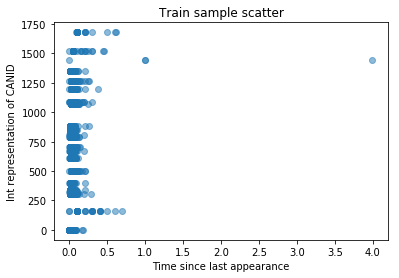

In [189]:
import matplotlib.pyplot as plt 
plt.scatter(simplified_train_data["Time since"], simplified_train_data.index,alpha=0.5)
plt.title('Train sample scatter')
plt.xlabel('Time since last appearance')
plt.ylabel('Int representation of CANID')
plt.show()

In [190]:
simplified_train_data.shape
len(train_label)

7000

In [191]:
if 1 in train_label:
    print("aye")

aye


In [192]:
train_label

[0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,


In [193]:
#Let's try...KNN (it should be able to detect DOS)
classifier = KNeighborsClassifier(n_neighbors = 20)
classifier.fit(simplified_train_data,train_label)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=20, p=2,
           weights='uniform')

In [194]:
guesses = classifier.predict(simplified_test_data)
guesses

array([1, 1, 0, ..., 1, 0, 0])

In [195]:
classifier.score(simplified_test_data,test_label)

0.9863333333333333

In [196]:
print("Accuracy:",accuracy_score(test_label,guesses))
print("Recall:",recall_score(test_label,guesses))
print("Precision:",precision_score(test_label,guesses))
print("F1:",f1_score(test_label,guesses))

Accuracy: 0.9863333333333333
Recall: 0.9675925925925926
Precision: 0.994291151284491
F1: 0.9807602064758328


In [170]:
for ori, guess in zip(test_label,guesses):
    if ori != guess:
        print("huh")

In [23]:
# new_strain_data = pd.get_dummies(simplified_train_data)
# new_strain_data

In [24]:
#Encode string data to integer 
le = LabelEncoder()
train_data = simplified_train_data.apply(le.fit_transform)
test_data = simplified_test_data.apply(le.fit_transform)
train_data.head()

,data
CAN ID,
04f0,1362
0153,1366
02a0,46294
0440,59885
0000,0


In [25]:
#Encode data to matrix of integers
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(train_data)
train_data = enc.transform(train_data).toarray()

In [26]:
train_data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [27]:
#it killed the kernel now
enc.fit(test_data)
test_data = enc.transform(test_data).toarray()

In [28]:
test_data

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [99]:
#Let's try...KNN (it should be able to detect DOS)
classifier = KNeighborsClassifier(n_neighbors = 5)
start_time = time.time()
classifier.fit(train_data,train_label)
elapsed_time = time.time() - start_time

ValueError: setting an array element with a sequence.

In [ ]:
#Kernel died
new_train_data = pd.get_dummies(train_data)
new_train_data

In [30]:
# Encode string data to integer 
# le = LabelEncoder()
# train_data = train_data.apply(le.fit_transform)
# test_data = test_data.apply(le.fit_transform)
# train_data.head()

,Timestamp,CAN ID,Data size (bytes),data
743482,520021,0,1,0
68311,47729,12,1,25661
1051654,736072,18,1,1680
698067,488223,5,1,14627
2178975,1524919,0,1,0


In [31]:
# Encode data to matrix of integers
# enc = OneHotEncoder(handle_unknown='ignore')
# enc.fit(test_data)
# test_data = enc.transform(test_data).toarray()

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
enc.fit(train_data)
train_data = enc.transform(train_data).toarray()

In [28]:
#Let's try...KNN (it should be able to detect DOS)
classifier = KNeighborsClassifier(n_neighbors = 5)
start_time = time.time()
classifier.fit(train_data,train_label)
elapsed_time = time.time() - start_time

TypeError: float() argument must be a string or a number, not 'OneHotEncoder'

In [ ]:
elapsed_time

In [ ]:
guesses = classifier.predict(test_data)
guesses

In [ ]:
classifier.score(test_data,test_label)

In [176]:
print("Accuracy:",accuracy_score(test_label,guesses))
print("Recall:",recall_score(test_label,guesses))
print("Precision:",precision_score(test_label,guesses))
print("F1:",f1_score(test_label,guesses))

Accuracy: 0.8864840583742751
Recall: 0.406304163126593
Precision: 0.7818054995476987
F1: 0.5347163468168451


In [17]:
fuzzy_df.head()

,1478195721.903877,0545,8,d8,00,00.1,8a,00.2,00.3,00.4,00.5,R
0,1.478196e+09,02b0,5,ff,7f,00,05,49,R,NaN,NaN,NaN
1,1.478196e+09,0002,8,00,00,00,00,00,01,07,15,R
2,1.478196e+09,0153,8,00,21,10,ff,00,ff,00,00,R
3,1.478196e+09,0130,8,19,80,00,ff,fe,7f,07,60,R
4,1.478196e+09,0131,8,17,80,00,00,65,7f,07,9f,R


In [67]:
fuzzy_df[fuzzy_df['R'] == "T"].head(10)

,1478195721.903877,0545,8,d8,00,00.1,8a,00.2,00.3,00.4,00.5,R
1566,1.478196e+09,00df,8,8c,ab,f2,26,7a,29,1a,0c,T
1567,1.478196e+09,06ea,8,25,10,9c,ed,5b,16,2c,18,T
1568,1.478196e+09,02fd,8,3f,bd,68,f3,c3,4f,28,d4,T
1575,1.478196e+09,012d,8,35,45,99,cf,09,80,c7,77,T
1579,1.478196e+09,033a,8,1c,04,86,90,7f,08,7e,c9,T
1583,1.478196e+09,039f,8,0e,2c,1c,49,e7,58,f6,6d,T
1585,1.478196e+09,07e3,8,7e,67,f3,ce,18,db,45,23,T
1587,1.478196e+09,0491,8,57,b5,20,cc,ad,83,d4,ef,T
1588,1.478196e+09,0522,8,04,72,b8,73,8c,bc,1a,79,T
1589,1.478196e+09,02fd,8,02,fd,0b,1b,94,54,94,54,T


In [62]:
fuzzy_df[fuzzy_df['R'].isnull()].head()

,1478195721.903877,0545,8,d8,00,00.1,8a,00.2,00.3,00.4,00.5,R
0,1.478196e+09,02b0,5,ff,7f,00,05,49,R,NaN,NaN,NaN
18,1.478196e+09,02b0,5,ff,7f,00,05,7a,R,NaN,NaN,NaN
41,1.478196e+09,02b0,5,ff,7f,00,05,6b,R,NaN,NaN,NaN
59,1.478196e+09,02b0,5,ff,7f,00,05,1c,R,NaN,NaN,NaN
79,1.478196e+09,05f0,2,00,00,R,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
fuzzy_df[fuzzy_df['00.3'] == "T"].head()

,1478195721.903877,0545,8,d8,00,00.1,8a,00.2,00.3,00.4,00.5,R


In [66]:
fuzzy_df[fuzzy_df['00.1'] == "T"].head()

,1478195721.903877,0545,8,d8,00,00.1,8a,00.2,00.3,00.4,00.5,R


In [18]:
gear_df.head()

,1478193190.056566,0140,8,00,00.1,00.2,00.3,10,29,2a,24,R
0,1.478193e+09,02c0,8,15,00,00,00,00,00,00,00,R
1,1.478193e+09,0350,8,05,20,44,68,77,00,00,7e,R
2,1.478193e+09,0370,8,00,20,00,00,00,00,00,00,R
3,1.478193e+09,043f,8,10,40,60,ff,78,c4,08,00,R
4,1.478193e+09,0440,8,ff,00,00,00,ff,c4,08,00,R


In [58]:
gear_df[gear_df['R'] == "T"].head()

,1478193190.056566,0140,8,00,00.1,00.2,00.3,10,29,2a,24,R
2139,1.478193e+09,043f,8,01,45,60,ff,6b,00,00,00,T
2140,1.478193e+09,043f,8,01,45,60,ff,6b,00,00,00,T
2141,1.478193e+09,043f,8,01,45,60,ff,6b,00,00,00,T
2143,1.478193e+09,043f,8,01,45,60,ff,6b,00,00,00,T
2149,1.478193e+09,043f,8,01,45,60,ff,6b,00,00,00,T


In [19]:
rpm_df.head()

,1478191030.045114,0316,8,05,22,68,09,22.1,20,00,75,R
0,1.478191e+09,018f,8,fe,3b,00,00,00,3c,00,00,R
1,1.478191e+09,0260,8,19,22,22,30,ff,8f,6e,3f,R
2,1.478191e+09,02a0,8,60,00,83,1d,96,02,bd,00,R
3,1.478191e+09,0329,8,dc,b8,7e,14,11,20,00,14,R
4,1.478191e+09,0545,8,d8,00,00,83,00,00,00,00,R


In [59]:
rpm_df[rpm_df['R'] == "T"].head()

,1478191030.045114,0316,8,05,22,68,09,22.1,20,00,75,R
1707,1.478191e+09,0316,8,45,29,24,ff,29,24,00,ff,T
1710,1.478191e+09,0316,8,45,29,24,ff,29,24,00,ff,T
1711,1.478191e+09,0316,8,45,29,24,ff,29,24,00,ff,T
1712,1.478191e+09,0316,8,45,29,24,ff,29,24,00,ff,T
1715,1.478191e+09,0316,8,45,29,24,ff,29,24,00,ff,T
